# Part 2.2 - Train Final XGBoost model
Use the final training and testing data sets, containing statistical features and timeseries bottleneck features, to train an XGBoost classifier.

In [105]:
import cudf as gd
import pandas as pd
import numpy as np
import math
import xgboost as xgb
from termcolor import colored
import matplotlib.pyplot as plt


In [106]:
train_final_gd = gd.from_pandas(pd.read_pickle("train_gdf.pkl"))
test_final_gd = gd.from_pandas(pd.read_pickle("test_gdf.pkl"))

In [107]:
train_final_gd.head().to_pandas()

,object_id,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,mean_passband,mean_detected,...,bottleneck6,bottleneck7,bottleneck8,bottleneck9,bottleneck10,bottleneck11,bottleneck12,bottleneck13,bottleneck14,bottleneck15
0,39420562,0,0.1400,0.1440,0.1291,39.169300,0.125,15,3.161074,0.020134,...,1.468261,7.576413,8.293226,1.879002,7.890978,1.332858,5.112309,3.297431,5.024964,10.317993
1,39446441,0,0.3628,0.4729,0.0922,42.116398,0.058,15,3.264000,0.048000,...,3.096897,11.122347,11.219639,0.311517,5.098419,1.574665,5.603312,0.539440,4.548586,8.742866
2,39488530,0,0.2935,1.4029,0.4197,45.009701,0.052,15,2.967742,0.016129,...,2.294352,7.085366,9.345342,0.254227,4.393799,0.933248,4.269487,0.310794,4.531476,4.948567
3,39501380,0,0.2130,0.2166,0.0082,40.150097,0.105,52,2.933884,0.049587,...,7.761703,1.321868,6.200109,5.247353,2.655982,10.224794,3.501489,2.755973,19.987198,2.101239
4,39511222,0,0.0000,0.0000,0.0000,NaN,0.011,6,2.992481,0.105263,...,3.591950,5.538804,6.747208,0.311666,3.058627,1.451683,10.459453,4.461519,6.548871,6.281866


In [108]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

y = train_final_gd['target'].to_array()

classes = sorted(np.unique(y))

print(classes)

[6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]


In [109]:
# Build classes with labels from [0, n-1]
lbl = LabelEncoder()
y = lbl.fit_transform(y)

Set our class weights and build a multi-weighted cross-entropy loss function to train our XGBoost model

In [110]:
def multi_weighted_logloss(y_true, y_preds, classes, class_weights):
    """
    Computes the weighted cross-entropy 
    refactor from
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true) # one-hot encodes y_true values
    
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)

    # Transform to log
    y_p_log = np.log(y_p)
    
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)

    # Weight average and divide by the number of positives
    class_arr = np.array([class_weights[k] for k in sorted(class_weights.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    
    return loss

def xgb_multi_weighted_logloss(y_predicted, y_true, classes, class_weights):
    loss = multi_weighted_logloss(y_true.get_label(), y_predicted, 
                                  classes, class_weights)
    return 'wloss', loss

In [111]:
from functools import partial

# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
class_weights = {c: 1 for c in classes}
class_weights.update({c:2 for c in [64, 15]})

func_loss = partial(xgb_multi_weighted_logloss, 
                    classes=classes, 
                    class_weights=class_weights)

Preprocess our columns to fill `nan` values with zeros

In [112]:
cols = [i for i in test_final_gd.columns if i not in ['object_id','target']]
for col in cols:
    train_final_gd[col] = train_final_gd[col].fillna(0).astype('float32')

for col in cols:
    test_final_gd[col] = test_final_gd[col].fillna(0).astype('float32')

Perform a stratified split of our training dataset into 90% training and 10% validation datasets. 

In [113]:
X = train_final_gd[cols].as_matrix()
Xt = test_final_gd[cols].as_matrix()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,stratify=y)

Set the parameters for XGBoost to build our ensemble of trees   

In [114]:
gpu_params = {
            'objective': 'multi:softprob', 
            'tree_method': 'hist', 
            'nthread': 16, 
            'num_class':14,
            'max_depth': 7, 
            'silent':0,
            'subsample':0.7,
            'colsample_bytree': 0.7,
            "objective": "multi:softprob",
            "tree_method": "gpu_hist"
}

Build DMatrix objects with our train, validation, and test datasets 

In [115]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dvalid = xgb.DMatrix(data=X_test, label=y_test)
dtest = xgb.DMatrix(data=Xt)

Train our XGBoost model

In [116]:
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]

clf = xgb.train(gpu_params, 
                dtrain=dtrain,
                num_boost_round=60,
                evals=watchlist,
                feval=func_loss,
                early_stopping_rounds=10,
                verbose_eval=1000)

yp = clf.predict(dvalid)

gpu_loss = multi_weighted_logloss(y_test, yp, classes, class_weights)

ysub = clf.predict(dtest)

line = 'validation loss %.4f'%gpu_loss
print(colored(line,'green'))

[0]	eval-merror:0.254777	train-merror:0.20841	eval-wloss:1.78844	train-wloss:1.62456
Multiple eval metrics have been passed: 'train-wloss' will be used for early stopping.

Will train until train-wloss hasn't improved in 10 rounds.
[59]	eval-merror:0.178344	train-merror:0	eval-wloss:0.77239	train-wloss:0.026769
validation loss 0.7724


In [117]:
y_hat = clf.predict(dvalid)

In [118]:
y_pred = np.argmax(y_hat, axis=1)

Normalized confusion matrix


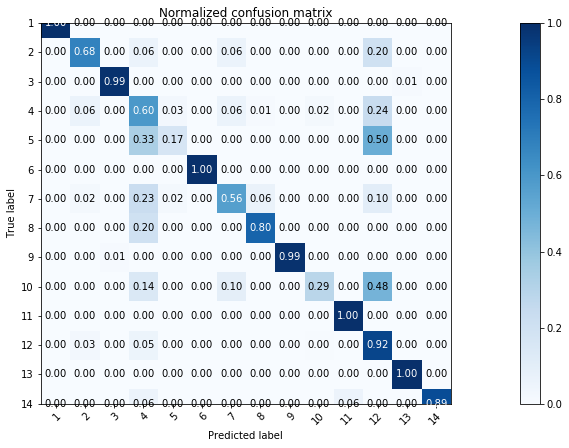

In [119]:
from utils import plot_confusion_matrix
plot_confusion_matrix(y_test, y_pred, np.arange(1, len(classes)+1), normalize=True)

## Independent Exercise

Now that you have trained an XGBoost model using both the timeseries embeddings and the statistical features,
1. re-run the previous notebook, but don't merge the timseries features into your training and test datasets before storing them. 
2. Use your new dataset to train a new XGBoost classifier. 
3. Compare the accuracy and confusion matrix against the model that included the timeseries embedding features. 